CNN

In [8]:
import torch
#(input channel, output channel, kerner size, stride, padding)
cnn1 = torch.nn.Conv2d(2,3, kernel_size=4, stride = 1, padding = 1)
cnn1.weight.data = torch.randint(1,5,size=(3,2,4,4),dtype=torch.int).float()
cnn1.bias.data = torch.tensor([1,2,3]).float() # bias zie is same as output dim
input = torch.randint(0,3, size=(2,5,5),dtype=torch.int).float()
output = cnn1(input)
print("input tensor size : ", input.shape)
print("cnn weight looks like",cnn1.weight)
print("bias looks like",cnn1.bias)
print("output :" ,output)
print("output shape is", output.shape)

input tensor size :  torch.Size([2, 5, 5])
cnn weight looks like Parameter containing:
tensor([[[[2., 3., 2., 2.],
          [4., 1., 4., 3.],
          [4., 3., 2., 3.],
          [1., 3., 2., 1.]],

         [[4., 1., 3., 2.],
          [3., 2., 2., 1.],
          [3., 3., 4., 1.],
          [3., 1., 2., 4.]]],


        [[[1., 4., 1., 2.],
          [1., 1., 4., 3.],
          [3., 1., 1., 3.],
          [3., 1., 4., 4.]],

         [[3., 3., 1., 2.],
          [2., 3., 2., 2.],
          [1., 4., 2., 2.],
          [1., 3., 3., 3.]]],


        [[[4., 1., 3., 4.],
          [4., 4., 4., 1.],
          [1., 3., 2., 2.],
          [3., 3., 1., 3.]],

         [[1., 2., 1., 2.],
          [2., 4., 1., 2.],
          [1., 3., 4., 1.],
          [3., 3., 4., 2.]]]], requires_grad=True)
bias looks like Parameter containing:
tensor([1., 2., 3.], requires_grad=True)
output : tensor([[[29., 40., 39., 27.],
         [37., 62., 61., 53.],
         [44., 74., 67., 69.],
         [31., 73., 63.

Pooling

In [10]:
input = torch.tensor([[[12 , 20 , 30, 0 ],
                       [8  , 12 , 2 , 0 ],
                       [34 , 70 , 37, 4 ],
                       [112, 100, 25, 12]]])
maxpool = torch.nn.MaxPool2d(kernel_size=2,stride=2 , padding=0)
avgpool = torch.nn.AvgPool2d(kernel_size=2,stride=2,padding=0)
print("Maxpooling output : ", maxpool(input))
print("Avgpooling output : ", avgpool(input))

Maxpooling output :  tensor([[[ 20,  30],
         [112,  37]]])
Avgpooling output :  tensor([[[13,  8],
         [79, 19]]])


example- MNIST

epoch 0 loss 0.17378451353681684
epoch 2 loss 0.03618910432289809
epoch 4 loss 0.023170179170521617
epoch 6 loss 0.0174140843966388
epoch 8 loss 0.011672014613762244


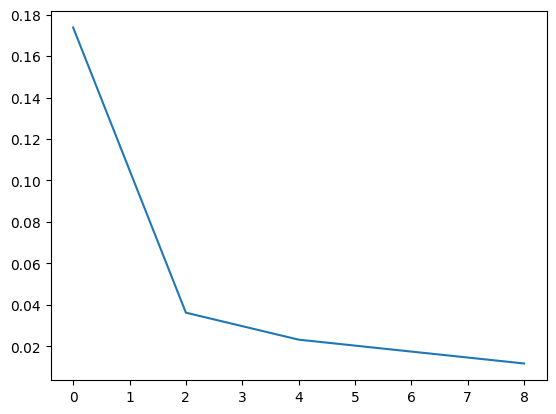

accuracy : 98.93%


In [3]:
from prompt_toolkit import history
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#prerocessing
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5),(0.5)) # mean, std
    ]
)
#download data
#(60000,1,28,28) : it has 60000 images with 28 by 28 size and black&white
trainset = torchvision.datasets.MNIST(root='./data',train=True, download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data',train=False, download=True,transform=transform)

#make batch for stablizing training
train_loader = DataLoader(trainset,batch_size=128,shuffle=True)
test_loader = DataLoader(testset,batch_size=128,shuffle=False)

# define simple CNN net
class CNN(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    #input size (1,28,28)
    self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
    self.fc1 = nn.Linear(64*7*7,128)
    self.fc2 = nn.Linear(128,10)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()

  def forward(self,x):
    x = self.pool(self.relu(self.conv1(x))) # (32,14,14)
    x = self.pool(self.relu(self.conv2(x))) # (64,7,7)
    x = self.flatten(x) # (64*7*7)
    x = self.fc1(x) # (128)
    x = self.fc2(x) #(10)
    return x
#generate instances
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
epochs = 10
history = {
    "epoch" : [],
    "loss" :[]
}

def train(model,trainset,loss,optimizer,num_epochs):
  for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainset :
      images, labels = images.to(device),labels.to(device)
      outputs = model(images)
      optimizer.zero_grad()
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    if epoch % 2 == 0 :
      history["epoch"].append(epoch)
      history["loss"].append(running_loss/len(trainset))
      print("epoch",epoch,"loss",running_loss/len(trainset))

def evaluate(model,test_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for imgs, lbs in test_loader :
      imgs,lbs = imgs.to(device),lbs.to(device)
      outputs = model(imgs)
      # max -> (output, index)
      _, pred = torch.max(outputs.data,1)
      total += lbs.size(0)
      correct += (pred == lbs).sum().item()
  print(f'accuracy : {100*correct/total:.2f}%')

train(model,train_loader,criterion,optimizer,epochs)
plt.plot(history["epoch"],history["loss"])
plt.show()
evaluate(model,test_loader)
